# Variational Dicke State Preparation

In [1]:
# Imports
import math
import cmath
%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from numpy import linalg as la
from scipy import linalg as sla
from scipy.special import binom
from IPython.display import clear_output
import time
import pickle
from qiskit.extensions import XGate, UnitaryGate
from qiskit import *
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import itertools
import pickle
from datetime import datetime

from qiskit.quantum_info.synthesis import two_qubit_cnot_decompose as two_qubit_decomp

X = np.matrix([[0,1],[1,0]],dtype=complex)
Y = np.matrix([[0,-1j],[1j,0]],dtype=complex)

swap = np.array([[1,0,0,0],
                 [0,0,1,0],
                 [0,1,0,0],
                 [0,0,0,1]])

# Local import
from DickeCircuit import DickeCirc, DickeCountParam
from DickeStates import Dicke_exp

In [2]:
def pswap(theta):
    
    mat = np.array([[1,0,0,0],[0,np.cos(theta),-np.sin(theta),0],[0,np.sin(theta),np.cos(theta),0],[0,0,0,1]])
    
    return mat

In [3]:
def keys_fun(n,k):
    result = []
    for bits in itertools.combinations(range(n), k):
        s = ['0'] * n
        for bit in bits:
            s[bit] = '1'
        result.append(''.join(s))
    return result

In [4]:
def DickeCounts(n,k,layer,theta,shots,init):
    qc = DickeCirc(n,k,layer,theta,init)
    qc.measure(range(n),range(n))
    backend      = Aer.get_backend("qasm_simulator")
    simulate     = execute(qc, backend=backend, shots=shots)
    counts = simulate.result().get_counts()
    return counts

In [20]:
def objG(theta,constants):
    
    n = constants[0]
    k = constants[1]
    layer = constants[2]
    shots = constants[3]
    init = constants[4]
        
    keys = keys_fun(n,k)
    
    num = 3
    
    counts_dict_list = []
    for i in range(num):
        counts_dict_list.append(DickeCounts(n,k,layer,theta,shots,init))
    
    counts_avg = []
    for key in keys:
        c_list = []
        for i in range(num):
            if key in counts_dict_list[i]:
                c_list.append(counts_dict_list[i][key])
            else:
                c_list.append(0)
        counts_avg.append(np.average(c_list))

    return np.std(counts_avg)

def objG_state_overlap(theta,constants):
    
    n = constants[0]
    k = constants[1]
    layer = constants[2]
    shots = constants[3]
    init = constants[4]
       
    counts = DickeCounts(n,k,layer,theta,shots,init)
    optimal = binom(n,k)
    dotproduct = 0
    for key,value in counts.items():
        dotproduct += math.sqrt(value/shots)

    return (1 - dotproduct**2/optimal)

In [21]:
def state_overlap(counts):
       
    optimal = binom(n,k)
    keys = keys_fun(n,k)
    
    dotproduct = 0
    for key,value in counts.items():
        if key in keys:
            dotproduct += math.sqrt(value/shots)

    return dotproduct**2/optimal

In [7]:
#prepares a Dicke state with given n and k
#returns the circuit

objf = objG_state_overlap

def Dicke(n,k,layer,shots,init):
    
    n_theta = DickeCountParam(n,k,layer)
    constants = [n,k,layer,shots,init]

    theta = []
    for i in range(n_theta):
        theta.append(np.random.uniform(0,2*np.pi))

    x_list = []
    def callback(x):
        x_list.append(objf(x,constants))
        itr = np.linspace(1,len(x_list),len(x_list))
        plt.plot(itr,x_list)
        clear_output(wait=True)
        plt.show()

    opt = sp.optimize.minimize(objf, x0=theta, args=constants, method = 'Powell', callback=callback)
    theta_min = opt.x
    print(theta_min)

    counts_min = DickeCounts(n,k,layer,theta_min,shots,init)
    print(counts_min)

    std_best = objf(theta_min,constants)
    print(std_best)
    
    return theta_min

#     ##simulation of the circuit with the right parameters
#     return DickeCirc(n,k,layer,theta_min,init)

In [51]:
n = 5
k = 2
layer = 4
shots = 2000 
init = 'pure'

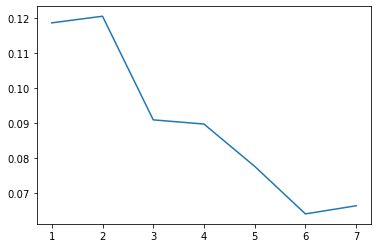

[4.87705054 5.84019336 2.40695927 1.574626   2.51792427 2.21918157
 4.09341665 0.40060597]
{'00110': 332, '00101': 186, '10001': 352, '11000': 88, '01001': 239, '01010': 64, '00011': 117, '10100': 111, '01100': 252, '10010': 259}
0.051454987788164486


In [52]:
theta_min = Dicke(n,k,layer,shots,init)

In [55]:
# Pickle dump
pickle.dump(theta_min,open("D" + str(n) + str(k) + "_theta_min", "wb"))

0.9384902072482157


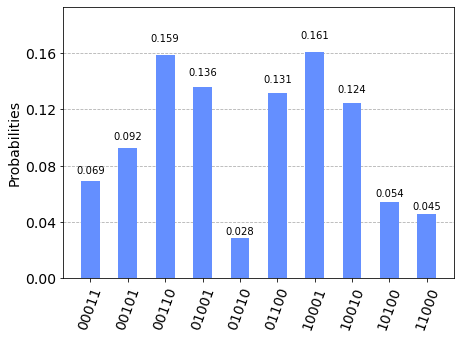

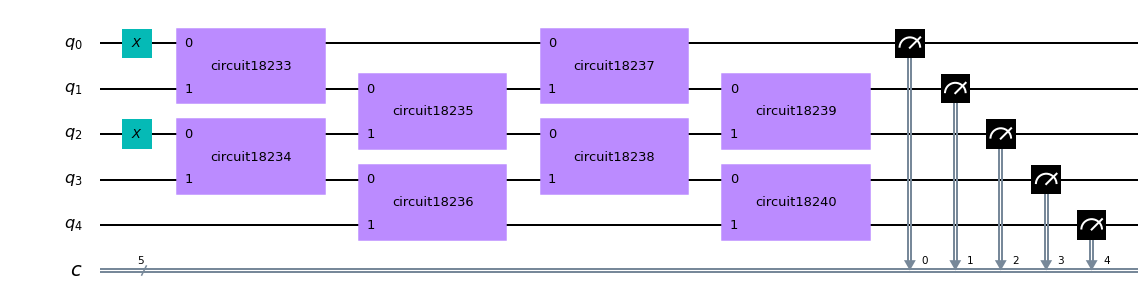

In [61]:
# No noise
shots = 2048

theta_min = pickle.load(open("D" + str(n) + str(k) + "_theta_min","rb"))

qc = DickeCirc(n,k,layer,theta_min,init)

# display (qc.draw(output='mpl'))

# qc = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)

qc.measure(range(n),range(n))
backend = Aer.get_backend("qasm_simulator")
simulate = execute(qc, backend=backend, shots=shots)
results = simulate.result()

counts = results.get_counts()

print(state_overlap(counts))

display(plot_histogram(counts))

qc.draw(output='mpl')

ibmqfactory.load_account:WARNING:2020-10-09 03:14:35,073: Credentials are already in use. The existing account in the session will be replaced.


0.8006682758755668


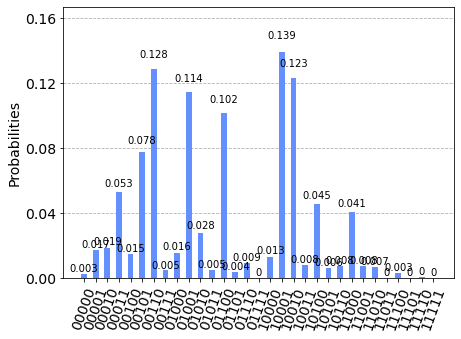

In [65]:
# Noise

# Shots
shots = 2048

theta_min = pickle.load(open("D" + str(n) + str(k) + "_theta_min","rb"))

qc = DickeCirc(n,k,layer,theta_min,init)

# display (qc.draw(output='mpl'))

qc.measure(range(n),range(n))

qc = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)

provider = IBMQ.load_account()
from qiskit.providers.aer.noise import NoiseModel

# Quantum device to simulate noise of
backend = provider.get_backend('ibmq_santiago')

# Noise Model
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

# Job from noisey simulation
job = qiskit.execute(qc, Aer.get_backend('qasm_simulator'), noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates, shots=shots)     

counts = job.result().get_counts()

print(state_overlap(counts))

plot_histogram(counts)

## Test against explicit method

0.998180653841508


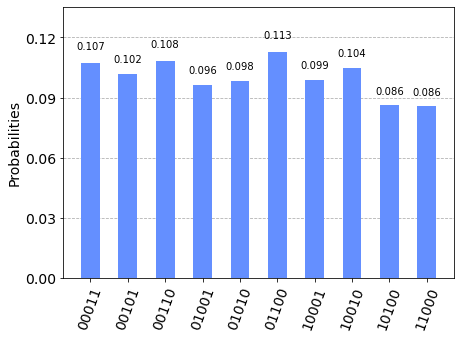

In [66]:
# No noise
shots = 2048

qc = Dicke_exp(n,k)

# display (qc.draw(output='mpl'))

qc.measure(range(n),range(n))
backend = Aer.get_backend("qasm_simulator")
simulate = execute(qc, backend=backend, shots=shots)
results = simulate.result()

counts = results.get_counts()

print(state_overlap(counts))

plot_histogram(counts)

ibmqfactory.load_account:WARNING:2020-10-09 03:15:32,374: Credentials are already in use. The existing account in the session will be replaced.


0.6411911993893625


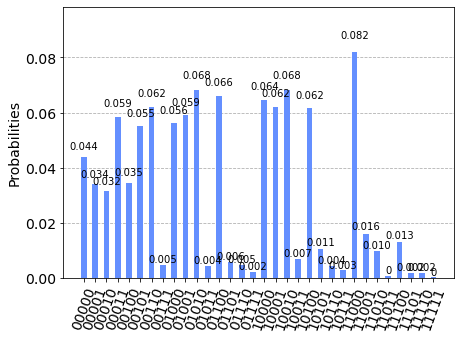

In [72]:
# Noise

# Shots
shots = 2048

qc = Dicke_exp(n,k)

# display (qc.draw(output='mpl'))

qc.measure(range(n),range(n))

qc = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)

provider = IBMQ.load_account()
from qiskit.providers.aer.noise import NoiseModel

# Quantum device to simulate noise of
backend = provider.get_backend('ibmq_santiago')

# Noise Model
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

# Job from noisey simulation
job = qiskit.execute(qc, Aer.get_backend('qasm_simulator'), noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates, shots=shots)     

counts = job.result().get_counts()

print(state_overlap(counts))

plot_histogram(counts)